In [1]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, ks_2samp

In [2]:
def df_gen(RESULTS_DIR, NSHARDS=10):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [3]:
def smoothed_plot_perf_vs_metric(
    df: pd.DataFrame,
    models: list[str],
    perf_meas: str,
    metric: str,
    n_bins: int = 10,
    figsize: tuple[int, int] = (8, 5),
    cmap: str = 'tab10'
):
    """
    Plot smoothed binned performance vs. metric for multiple models,
    with shaded 95% confidence intervals around the mean.

    Parameters
    ----------
    df : DataFrame
        Must contain the column [metric] and, for each model in `models`,
        a performance column named model+perf_meas (e.g. 'GCN'+'accuracy' → 'GCNaccuracy').
    models : list of str
        Model-name prefixes.
    perf_meas : str
        Performance-measure suffix (e.g. 'f1_macro', 'accuracy').
    metric : str
        The continuous metric to bin (e.g. 'homophily_rate').
    n_bins : int, default=10
        Number of equal-width bins to split the metric into.
    figsize : (width, height)
        Figure size.
    cmap : str
        Matplotlib colormap for the model curves.
    """
    # 1. Create equal-width bins and label them by their center values
    bin_edges = np.linspace(df[metric].min(), df[metric].max(), n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)


    # 2. Initialize plot
    plt.figure(figsize=figsize)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(models)))

    # 3. For each model, compute mean and 95% CI in each bin and plot
    for model, color in zip(models, colors):
        col = f"{model}__{perf_meas}"
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")

        grp = df.groupby('_bin')[col]
        count = grp.count()                    # number of observations per bin
        mean = grp.mean()                      # mean performance per bin
        std  = grp.std(ddof=1)                 # sample standard deviation
        sem  = std / np.sqrt(count)            # standard error of the mean
        ci95 = 1.96 * sem                      

        # Only keep bins with data
        valid = count > 0
        x     = mean.index.astype(float)[valid]
        y     = mean[valid]
        lower = y - ci95[valid]
        upper = y + ci95[valid]

        # Plot mean line and shaded 95% CI
        plt.plot(x, y, label=model, color=color, linewidth=2)
        plt.fill_between(x, lower, upper, color=color, alpha=0.3)

    # 4. Final styling
    plt.xlabel(metric)
    plt.ylabel(perf_meas)
    plt.ylim(0,1)
    plt.title(f"{perf_meas} vs {metric} (binned, with 95% CI)")
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Clean up temporary column
    df.drop(columns=['_bin'], inplace=True)

In [13]:
def boxplots(df, models, metric):
    plt.boxplot(df[[f'{model}__{metric}' for model in models]], tick_labels= models)
    plt.ylabel(f'{metric}')
    plt.show()

In [5]:
def compute_and_plot_graph_metric_correlations(
    df: pd.DataFrame,
    graph_metrics: list,
    models: list,
    perf_suffix: str = "test_f1_macro",
    corr_method: str = "pearson",
    figsize: tuple = (10, 8)
):
    """
    1) Filters df to rows where 'feature_dim' == feature_dim.
    2) For each graph‐metric in graph_metrics, compute its correlation (Pearson or Spearman)
       against each model’s performance column: f"{model}__{perf_suffix}".
    3) Plots the resulting correlation matrix as a heatmap.

    Args:
      df:            The full DataFrame containing your results and graph_metrics.
      graph_metrics: List of column‐names (strings) that describe graph‐level metrics.
      models:        List of model‐prefixes, e.g. ['MLP','GCN','HGCN'].
      perf_suffix:   The suffix of the performance column, e.g. "test_f1_macro".
      corr_method:   "pearson" or "spearman".
      figsize:       Size of the final figure.
    Returns:
      corr_df:       A DataFrame of shape (len(graph_metrics) × len(models)), containing
                     correlation coefficients.
    """

    df16 = df

    # 2) Build an empty DataFrame to hold correlation coefficients
    corr_df = pd.DataFrame(
        index=graph_metrics,
        columns=models,
        dtype=float
    )

    # 3) For each model, for each graph_metric, compute correlation w.r.t. performance
    for model in models:
        perf_col = f"{model}__{perf_suffix}"
        if perf_col not in df16.columns:
            raise KeyError(f"Performance column {perf_col} not found in DataFrame.")

        # We’ll drop NaNs pairwise
        for metric in graph_metrics:
            if metric not in df16.columns:
                raise KeyError(f"Graph‐metric column {metric} not found in DataFrame.")
            sub = df16[[metric, perf_col]].dropna()

            # Now drop any rows where either value is not finite (inf or NaN).
            # (pearsonr / spearmanr require strictly finite inputs.)
            x = sub[metric].values
            y = sub[perf_col].values
            finite_mask = np.isfinite(x) & np.isfinite(y)
            x_finite = x[finite_mask]
            y_finite = y[finite_mask]

            # If fewer than 3 points remain, correlation is not well-defined:
            if x_finite.shape[0] < 3:
                corr_val = np.nan
            else:
                if corr_method == "pearson":
                    corr_val, _ = pearsonr(x_finite, y_finite)
                elif corr_method == "spearman":
                    corr_val, _ = spearmanr(x_finite, y_finite)
                else:
                    raise ValueError("corr_method must be 'pearson' or 'spearman'.")

            corr_df.loc[metric, model] = corr_val

    # 4) Plot a heatmap of those correlation coefficients
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr_df.astype(float),
        annot=True,
        fmt=".2f",
        cmap="RdBu_r",
        center=0.0,
        cbar_kws={"label": f"{corr_method.title()} correlation"}
    )
    plt.title(f"{corr_method.title()} correlations")
    plt.ylabel("Graph‐level metric")
    plt.xlabel("Model")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return corr_df

In [7]:
RESULTS_DIR = '../../../graph_gen/snellius_gen/lp/rq1/rq1/1'
df = df_gen(RESULTS_DIR)

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


In [11]:
df.columns

Index(['nvertex', 'avg_degree', 'feature_center_distance', 'feature_dim',
       'edge_center_distance', 'edge_feature_dim', 'p_to_q_ratio',
       'num_clusters', 'cluster_size_slope', 'power_exponent',
       'generator_name', 'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'approximate_diameter', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc',
       'skipped', 'sample_id', 'MLP__test_rocauc', 'MLP__test_ap',
       'MLP__model_dropout', 'MLP__model_hidden_channels',
       'MLP__model_in_channels', 'MLP__model_lr', 'MLP__model_num_layers',
       'MLP__model_weight_decay', 'MLP__model_out_cha

In [19]:
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'approximate_diameter', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

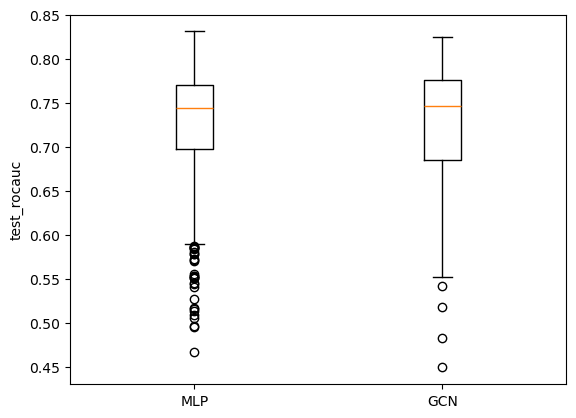

In [15]:
models = ['MLP', 'GCN']
metric = 'test_rocauc'
boxplots(df, models, metric)

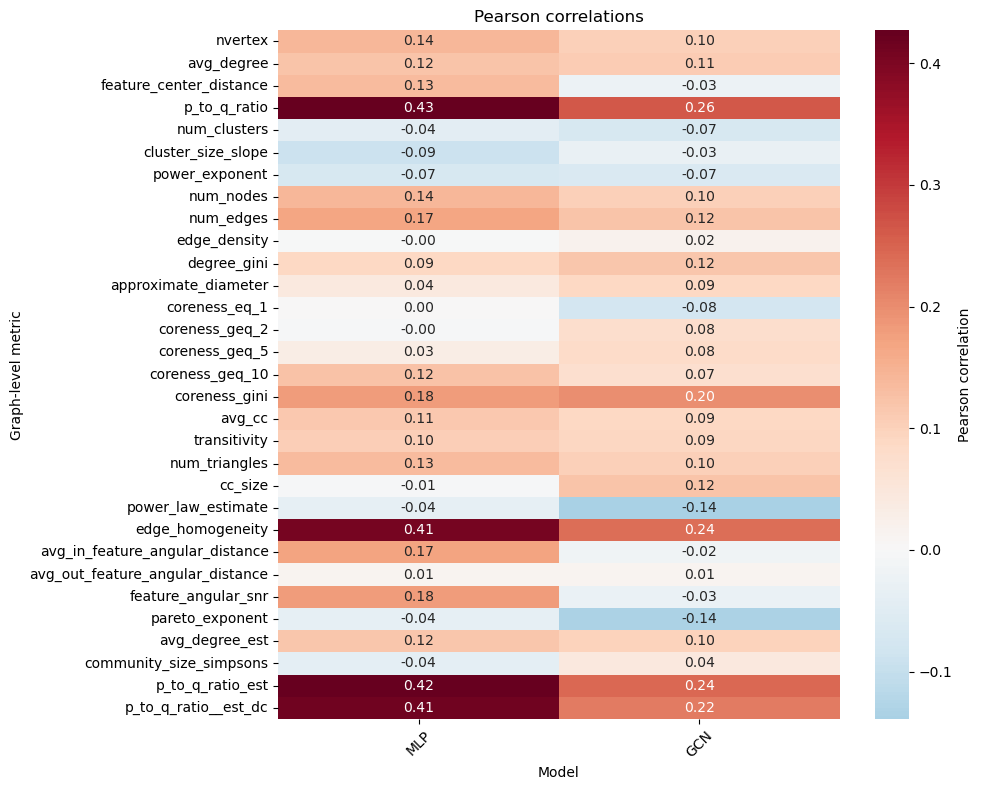

,MLP,GCN
nvertex,0.142933,0.101035
avg_degree,0.120018,0.106880
feature_center_distance,0.134726,-0.025112
p_to_q_ratio,0.426927,0.263811
num_clusters,-0.044661,-0.070958
cluster_size_slope,-0.090553,-0.031797
power_exponent,-0.069151,-0.065805
num_nodes,0.142908,0.101271
num_edges,0.167069,0.121565
edge_density,-0.001158,0.018429


In [20]:
compute_and_plot_graph_metric_correlations(df, graph_metrics, models, perf_suffix='test_rocauc')

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


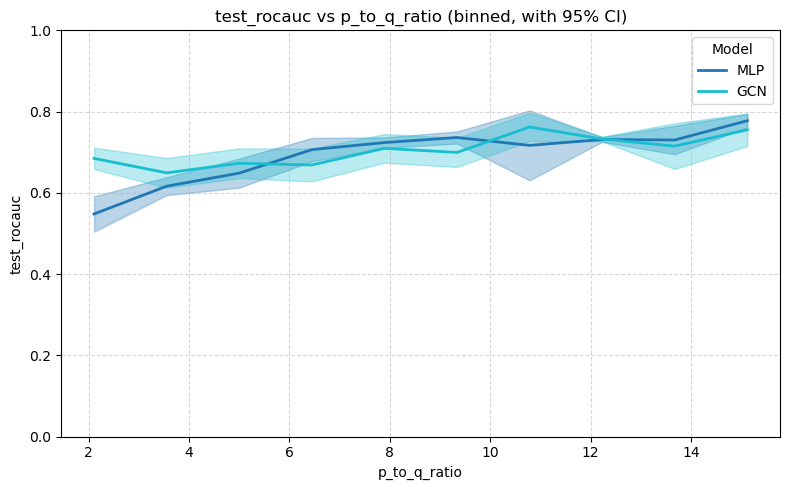

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


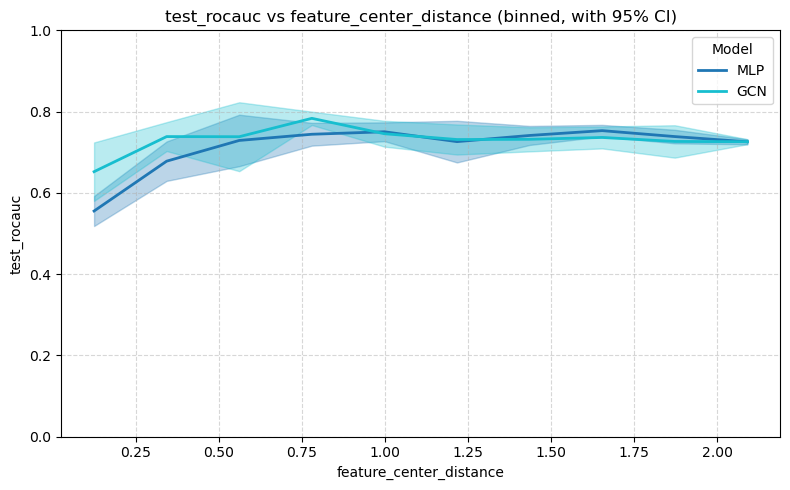

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


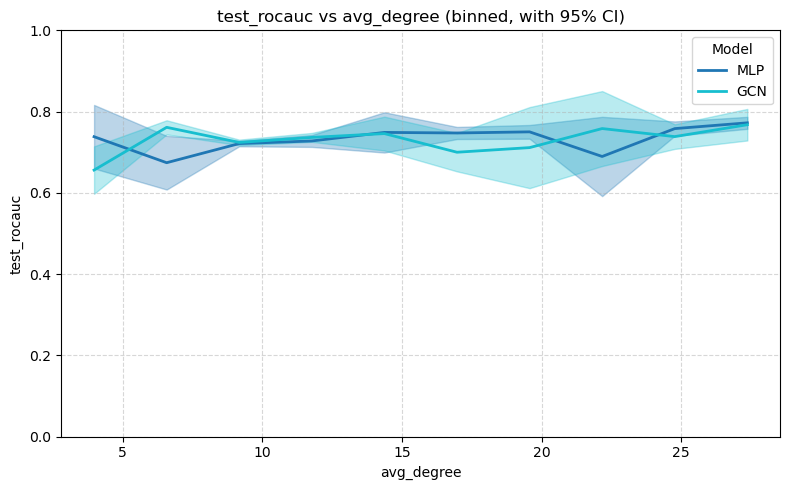

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


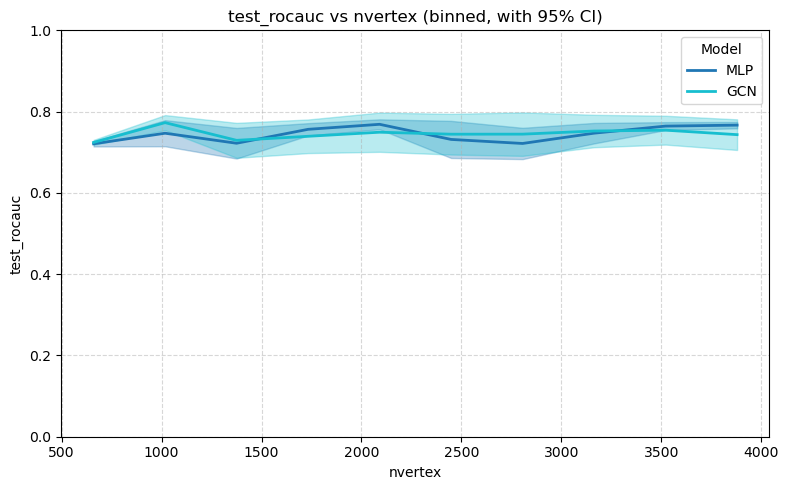

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_12545/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]


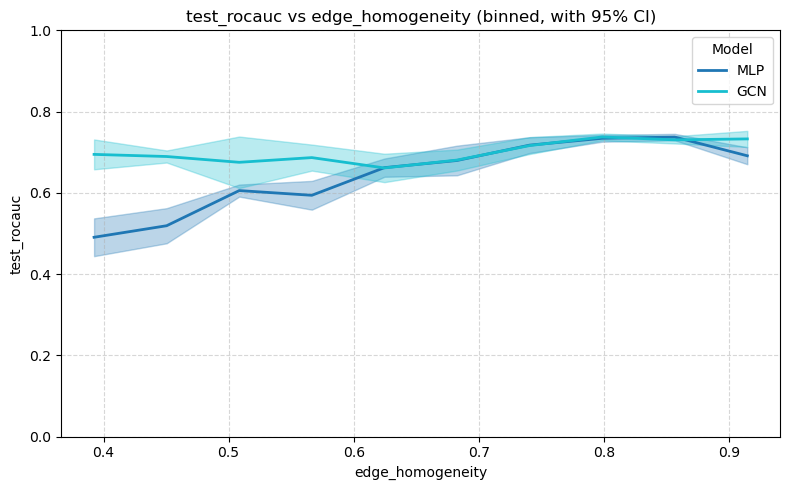

In [21]:
metrics_of_interest = ['p_to_q_ratio', 'feature_center_distance', 'avg_degree', 'nvertex', 'edge_homogeneity']
for m in metrics_of_interest:
    smoothed_plot_perf_vs_metric(df, models, perf_meas='test_rocauc', metric = m)